### TF-IDF vs Word2Vec: Advantages and Disadvantages

**TF-IDF** (Term Frequency-Inverse Document Frequency) and **Word2Vec** are both prominent methods for transforming text data into numerical form for machine learning models. However, they serve different purposes and have distinct strengths and weaknesses.

#### **TF-IDF**

**Advantages:**

1. **Simplicity**: TF-IDF is straightforward to implement and interpret, making it an accessible choice for many applications.
2. **Interpretability**: The model's output (TF-IDF scores) can be directly interpreted as the importance of words within documents relative to their frequency across a corpus.
3. **Scalability**: TF-IDF calculations are computationally light compared to deep learning models, making it suitable for large datasets.
4. **Effectiveness**: Performs well in tasks like document classification and keyword extraction, where the frequency of words is a strong indicator of relevance.

**Disadvantages:**

1. **Sparse Representations**: TF-IDF often results in vectors with many zero values, which can be inefficient in terms of storage and computational resources.
2. **Lack of Context Awareness**: It does not consider the context in which words appear, treating each word as an independent feature.
3. **No Word Similarity**: TF-IDF does not capture semantic relationships between words, limiting its utility for tasks requiring a deep understanding of language semantics.

#### **Word2Vec**

**Advantages:**

1. **Semantic Information**: Captures complex semantic relationships between words by learning from the contexts in which they appear.
2. **Dense Representations**: Produces dense vectors (with fewer zeros), encapsulating more information in a more compact format.
3. **Transferability**: Trained embeddings can be reused effectively across different tasks, benefiting from transfer learning.
4. **Dynamic Learning**: Can be updated with new words more efficiently than TF-IDF, which requires a complete re-computation for new documents.

**Disadvantages:**

1. **Training Complexity**: Requires significant computational resources and large amounts of text data for effective training.
2. **Interpretability Issues**: The vectors are less interpretable, as each dimension does not correspond to specific words or clear features.
3. **Handling of Rare Words**: Struggles with rare words that may not appear frequently enough to be well-represented.
4. **Fixed Word Meaning**: Typically assigns a single vector per word, ignoring different meanings based on context, though newer models like BERT address this limitation.

#### **Conclusion**

The choice between TF-IDF and Word2Vec depends on the specific application requirements. TF-IDF is well-suited for applications where basic word frequency metrics suffice, such as document retrieval and some forms of classification. Word2Vec is preferable for tasks that benefit from a deep semantic understanding of text, like sentiment analysis, machine translation, or sophisticated conversational systems.

## TF-IDF

convert to dataframe and set the column name


In [49]:
import csv
import pandas as pd

In [50]:
def read_tsv(file_path: str) -> list:
    data = []
    with open(file_path, 'r', encoding='utf-8') as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        for row in reader:
            data.append(row)
    return data

In [51]:
file_path = 'SpamVsHam.tsv'
data = read_tsv(file_path)

# convert to dataframe and set the column name
data = pd.DataFrame(data,  columns=['label', 'text'])
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


split dataset to training and validation

In [52]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(data['text'], 
                                                  data['label'], 
                                                  test_size=0.20, 
                                                  random_state=0)

# 再將訓練集+驗證集分割成訓練集和驗證集
X_train, X_val, y_train, y_val = train_test_split(X_temp, 
                                                  y_temp, 
                                                  test_size=0.25, # 注意這裡設置為0.25是因為原本0.8的數據要再取0.2作為驗證集，0.25 * 0.8 = 0.2
                                                  random_state=0)

# check the size of our datasets
print('Size of training set:',X_train.shape)
print('Size of validation set:',X_val.shape)
print('Size of test set:', X_test.shape)

Size of training set: (3342,)
Size of validation set: (1115,)
Size of test set: (1115,)


Create a TF-IDF Vectorizer object

Fit the model and transform the documents

Get the list of words and their corresponding TF-IDF values

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Create a TF-IDF Vectorizer object
tfidf = TfidfVectorizer(decode_error='ignore', lowercase=True, min_df=2)

# Fit the model and transform the documents
train = tfidf.fit_transform(X_train.values.astype('U'))

val = tfidf.transform(X_val.values.astype('U'))

test = tfidf.transform(X_test.values.astype('U'))

# Get the list of words and their corresponding TF-IDF values
print('Train size: ',train.shape)
print('Val size: ',val.shape)
print('Test size', test.shape)


Train size:  (3342, 2962)
Val size:  (1115, 2962)
Test size (1115, 2962)


create the model, train it on the train dataset and print the scores


In [54]:
import time
from sklearn.naive_bayes import MultinomialNB

start_time = time.time()

# create the model, train it on the train dataset and print the scores
model = MultinomialNB() # as implemented in sklearn
model.fit(train, y_train)

end_time = time.time()

training_time = end_time - start_time

print(f"Training completed in {training_time:.3f} seconds")
print("Train score:", model.score(train, y_train))
print("Validation score:", model.score(val, y_val))

Training completed in 0.020 seconds
Train score: 0.9778575703171754
Validation score: 0.967713004484305


Create the confusion matrix

Create a dataframe with the confusion matrix values

Plot the confusion matrix

In [55]:
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score

# Create the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confusion matrix
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10}) # font size
    plt.show()

In [56]:
# ROC Curve
# plot no skill
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       972
        spam       1.00      0.75      0.86       143

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.97      0.97      0.97      1115



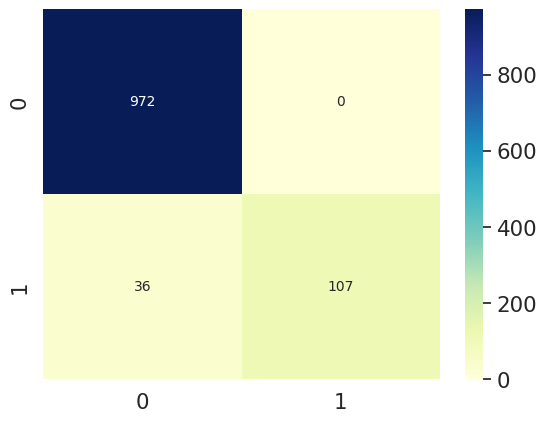

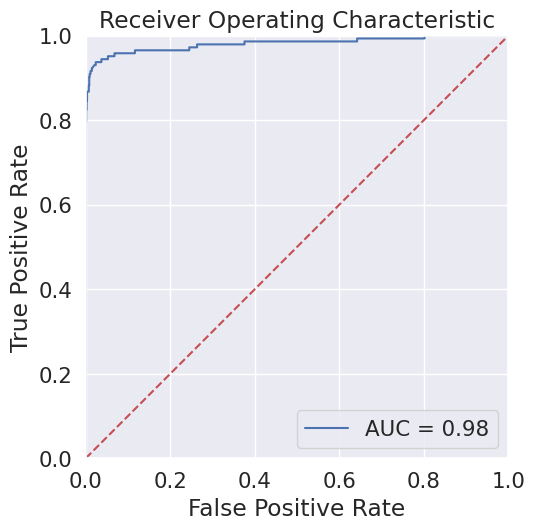

In [57]:
# Predicting the Test set results
y_pred = model.predict(val)

#print the classification report to highlight the accuracy with f1-score, precision and recall
print(metrics.classification_report(y_val, y_pred))
plot_confusion_matrix(y_val, y_pred)

# ROC curve needs the raw model probabilities, not the model predictions
y_pred_prob = model.predict_proba(val)[:,1]
plot_roc_curve(y_val.apply(lambda x: 1 if x == 'spam' else 0), y_pred_prob)


Define a LSTM model

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 將TF-IDF向量和標籤轉換成Tensor
train_data = torch.tensor(train.toarray(), dtype=torch.float32)
val_data = torch.tensor(val.toarray(), dtype=torch.float32)
test_data = torch.tensor(test.toarray(), dtype=torch.float32)
train_labels = torch.tensor(y_train.apply(lambda x: 1 if x == 'spam' else 0).values, dtype=torch.float32)
val_labels = torch.tensor(y_val.apply(lambda x: 1 if x == 'spam' else 0).values, dtype=torch.float32)
test_labels = torch.tensor(y_test.apply(lambda x: 1 if x == 'spam' else 0).values, dtype=torch.float32)

# 創建DataLoaders
train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定義LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            layer_dim,
            batch_first=True
        )
        # Dropout 層
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # 輸入x的維度應為(batch_size, 1, input_dim)
        x = x.unsqueeze(1)  # 增加序列維度
        
        # 初始化隱藏狀態和單元狀態
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        
        # 前向傳播
        out, (hn, cn) = self.lstm(x, (h0, c0))
        # Dropout 層
        out = self.drop(out[:, -1, :])
        # 全連接層
        out = self.fc(out)
        return torch.sigmoid(out)

# 實例化模型
input_dim = train_data.shape[1]  # TF-IDF特徵數量
hidden_dim = 100
layer_dim = 1
output_dim = 1
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

# 損失函數和優化器
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 訓練模型
def train_model(num_epochs):
    training_loss = []
    validation_loss = []
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        
        # 訓練階段
        model.train()
        for texts, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * texts.size(0)
        
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        training_loss.append(avg_train_loss)
        
        # 驗證階段
        model.eval()
        total_correct = 0
        total = 0
        with torch.no_grad():
            for texts, labels in val_loader:
                outputs = model(texts)
                loss = criterion(outputs.squeeze(), labels)
                total_val_loss += loss.item() * texts.size(0)
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                total_correct += (predicted == labels).sum().item()
        
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        validation_loss.append(avg_val_loss)
        
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
        print(f'Validation Accuracy: {100 * total_correct / total}%')
    
    return training_loss, validation_loss

# 訓練模型並繪圖
start_time = time.time()
training_loss, validation_loss = train_model(10)
end_time = time.time()

Epoch 1, Training Loss: 0.3018535112818332, Validation Loss: 0.07927471981989428
Validation Accuracy: 98.02690582959642%
Epoch 2, Training Loss: 0.04278570412697726, Validation Loss: 0.0638518663298656
Validation Accuracy: 97.9372197309417%
Epoch 3, Training Loss: 0.019837428732061194, Validation Loss: 0.06662819162470543
Validation Accuracy: 97.66816143497758%
Epoch 4, Training Loss: 0.009568117883330616, Validation Loss: 0.06787128313663812
Validation Accuracy: 98.20627802690584%
Epoch 5, Training Loss: 0.0042570340168455595, Validation Loss: 0.07452150476775905
Validation Accuracy: 98.38565022421524%
Epoch 6, Training Loss: 0.0024114427771775985, Validation Loss: 0.07649450819765014
Validation Accuracy: 97.9372197309417%
Epoch 7, Training Loss: 0.0012886960793579412, Validation Loss: 0.08378502146190558
Validation Accuracy: 98.20627802690584%
Epoch 8, Training Loss: 0.0007368508073229095, Validation Loss: 0.0852837992888902
Validation Accuracy: 98.29596412556054%
Epoch 9, Training L

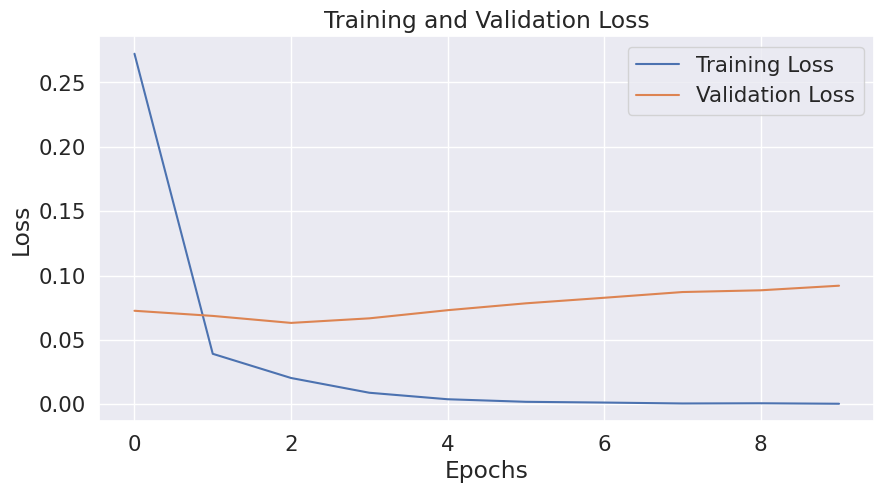

Total training time: 4.59 seconds


In [62]:
# 繪製損失圖
plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f'Total training time: {end_time - start_time:.2f} seconds')

In [63]:
import seaborn as sn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

def evaluate_model(model, data_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for texts, labels in data_loader:
            outputs = model(texts)
            predicted = (outputs.squeeze() > 0.5).float()
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

    # 計算指標
    print('Classification Report:')
    print(classification_report(y_true,y_pred,labels=[1,0], digits=4))
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # 混淆矩陣
    cm = confusion_matrix(y_true, y_pred)
    sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, precision, recall, f1

traing_time: 4.647134065628052
Classification Report:
              precision    recall  f1-score   support

           1     0.9742    0.9437    0.9587       160
           0     0.9906    0.9958    0.9932       955

    accuracy                         0.9883      1115
   macro avg     0.9824    0.9698    0.9760      1115
weighted avg     0.9883    0.9883    0.9883      1115



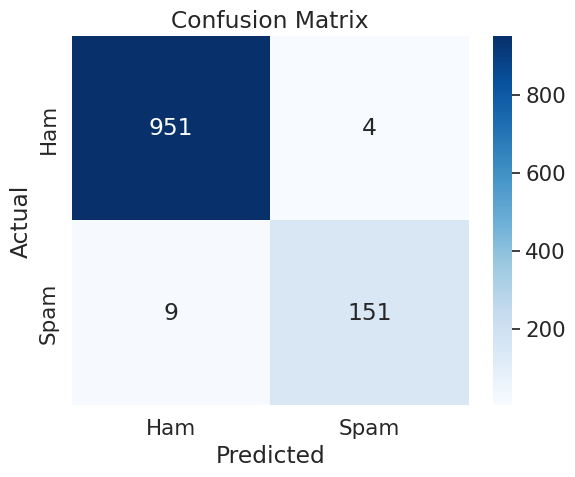

In [65]:
# 評估模型
print("traing_time:", end_time - start_time)
metrics = evaluate_model(model, test_loader)

## Word2Vec

Load data

In [16]:
file_path = 'SpamVsHam.tsv'
data = read_tsv(file_path)

# convert to dataframe and set the column name
data = pd.DataFrame(data,  columns=['label', 'text'])
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [17]:
import gensim
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [66]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(data['text'], 
                                                  data['label'], 
                                                  test_size=0.20, 
                                                  random_state=0)

# 再將訓練集+驗證集分割成訓練集和驗證集
X_train, X_val, y_train, y_val = train_test_split(X_temp, 
                                                  y_temp, 
                                                  test_size=0.25, # 注意這裡設置為0.25是因為原本0.8的數據要再取0.2作為驗證集，0.25 * 0.8 = 0.2
                                                  random_state=0)

# check the size of our datasets
print('Size of training set:',X_train.shape)
print('Size of validation set:',X_val.shape)
print('Size of test set:', X_test.shape)

Size of training set: (3342,)
Size of validation set: (1115,)
Size of test set: (1115,)


In [67]:
tokenized_sentences = [nltk.word_tokenize(doc.lower()) for doc in X_train.values.astype('U')]

In [68]:
model = Word2Vec(tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)
model.train(tokenized_sentences, total_examples=len(tokenized_sentences), epochs=10)

(479014, 627700)

In [69]:
import numpy as np

def document_vector(doc):
    words = nltk.word_tokenize(doc.lower())
    words = [word for word in words if word in model.wv]
    if not words:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[words], axis=0)

train_vectors = np.array([document_vector(doc) for doc in X_train.values.astype('U')])
val_vectors = np.array([document_vector(doc) for doc in X_val.values.astype('U')])
test_vectors = np.array([document_vector(doc) for doc in X_test.values.astype('U')])

ML model

In [70]:
import time
from sklearn.naive_bayes import GaussianNB

start_time = time.time()

# 使用 Gaussian Naive Bayes 模型
model = GaussianNB()
model.fit(train_vectors, y_train)
end_time = time.time()

print("Training time:", end_time - start_time)
print("Train score:", model.score(train_vectors, y_train))
print('Validation score:', model.score(val_vectors, y_val)) 

Training time: 0.01154470443725586
Train score: 0.9144225014961102
Validation score: 0.9255605381165919


              precision    recall  f1-score   support

         ham       0.98      0.93      0.96       972
        spam       0.65      0.89      0.75       143

    accuracy                           0.93      1115
   macro avg       0.82      0.91      0.85      1115
weighted avg       0.94      0.93      0.93      1115



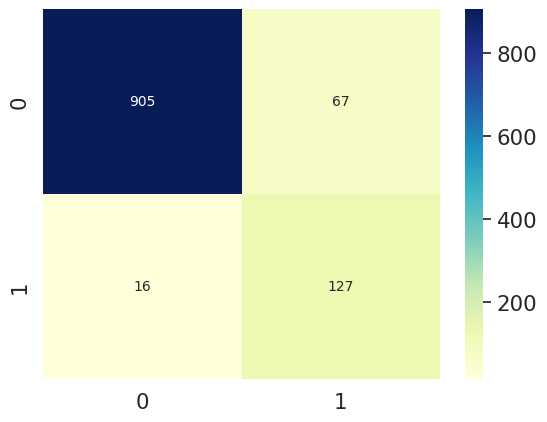

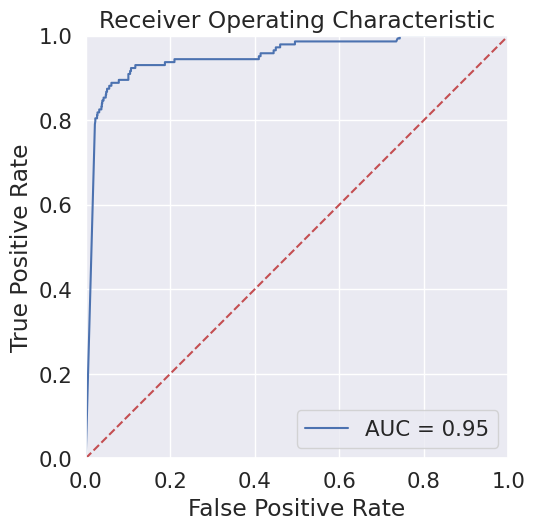

In [71]:
from sklearn import metrics

# Predicting the Test set results
y_pred = model.predict(val_vectors)

#print the classification report to highlight the accuracy with f1-score, precision and recall
print(metrics.classification_report(y_val, y_pred))
plot_confusion_matrix(y_val, y_pred)

# ROC curve needs the raw model probabilities, not the model predictions
y_pred_prob = model.predict_proba(val_vectors)[:,1]
plot_roc_curve(y_val.apply(lambda x: 1 if x == 'spam' else 0), y_pred_prob)

Word2Vec 產生連續型特徵：Word2Vec 模型輸出的是每個單詞的連續型向量表示，這些向量捕捉了詞彙在語義空間中的位置和關係。

Naive Bayes 假設：多數 Naive Bayes 的變體（如 MultinomialNB 和 BernoulliNB）主要設計用來處理離散或二元特徵。雖然 GaussianNB 適用於連續數據，但其假設每個特徵都符合高斯分佈（正態分佈），這對於 Word2Vec 的輸出可能不太適合。

Define a LSTM model

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# 將Word2Vec向量和標籤轉換成Tensor
train_data = torch.tensor(train_vectors, dtype=torch.float32)
val_data = torch.tensor(val_vectors, dtype=torch.float32)
test_data = torch.tensor(test_vectors, dtype=torch.float32)
train_labels = torch.tensor(y_train.apply(lambda x: 1 if x == 'spam' else 0).values, dtype=torch.float32)
val_labels = torch.tensor(y_val.apply(lambda x: 1 if x == 'spam' else 0).values, dtype=torch.float32)
test_labels = torch.tensor(y_test.apply(lambda x: 1 if x == 'spam' else 0).values, dtype=torch.float32)

# 創建DataLoaders
train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
test_dataset = TensorDataset(test_data, test_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, bidirectional=True, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0.0  # Dropout 只在多層 LSTM 中添加
        )
        self.dropout = nn.Dropout(p=dropout_rate)
        # 如果是雙向，需要考慮正反兩個方向的 hidden 狀態
        self.fc = nn.Linear(2 * hidden_dim if bidirectional else hidden_dim, output_dim)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # 增加序列維度
        out, (hn, cn) = self.lstm(x)
        out = self.dropout(out)
        # 選取序列中最後一個輸出的特徵
        out = self.fc(out[:, -1, :])
        return torch.sigmoid(out)

# 實例化模型
input_dim = train_data.shape[1]  # Word2Vec 特徵維度
hidden_dim = 100
output_dim = 1
num_layers = 1
bidirectional = True
dropout_rate = 0.5

model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout_rate)


In [73]:
# 損失函數和優化器
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 訓練模型
def train_model(num_epochs):
    training_loss = []
    validation_loss = []
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        
        # 訓練階段
        model.train()
        for texts, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * texts.size(0)
        
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        training_loss.append(avg_train_loss)
        
        # 驗證階段
        model.eval()
        total_correct = 0
        total = 0
        with torch.no_grad():
            for texts, labels in val_loader:
                outputs = model(texts)
                loss = criterion(outputs.squeeze(), labels)
                total_val_loss += loss.item() * texts.size(0)
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                total_correct += (predicted == labels).sum().item()
        
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        validation_loss.append(avg_val_loss)
        
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
        print(f'Validation Accuracy: {100 * total_correct / total}%')
    
    return training_loss, validation_loss

# 訓練模型並繪圖
start_time = time.time()
training_loss, validation_loss = train_model(10)
end_time = time.time()

Epoch 1, Training Loss: 0.2116769409260837, Validation Loss: 0.16697128479256224
Validation Accuracy: 94.08071748878923%
Epoch 2, Training Loss: 0.13203259623921038, Validation Loss: 0.14535693980319084
Validation Accuracy: 94.34977578475336%
Epoch 3, Training Loss: 0.13831322889425027, Validation Loss: 0.16660494417069072
Validation Accuracy: 94.43946188340807%
Epoch 4, Training Loss: 0.12804847953362888, Validation Loss: 0.1576101860449119
Validation Accuracy: 94.52914798206278%
Epoch 5, Training Loss: 0.11653581816192554, Validation Loss: 0.1440906177838688
Validation Accuracy: 94.61883408071749%
Epoch 6, Training Loss: 0.12981350673111808, Validation Loss: 0.13075536025913576
Validation Accuracy: 94.88789237668162%
Epoch 7, Training Loss: 0.12321388748218598, Validation Loss: 0.13826851522207528
Validation Accuracy: 94.88789237668162%
Epoch 8, Training Loss: 0.1162589803061608, Validation Loss: 0.12907099939982988
Validation Accuracy: 95.33632286995515%
Epoch 9, Training Loss: 0.11

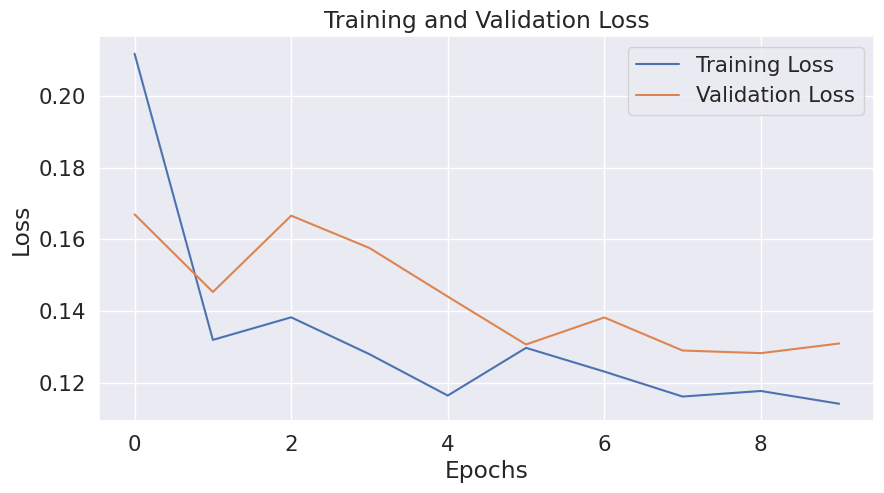

Total training time: 2.32 seconds


In [74]:
# 繪製損失圖
plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f'Total training time: {end_time - start_time:.2f} seconds')

In [75]:
import seaborn as sn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

def evaluate_model(model, data_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for texts, labels in data_loader:
            outputs = model(texts)
            predicted = (outputs.squeeze() > 0.5).float()
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

    # 計算指標
    print('Classification Report:')
    print(classification_report(y_true,y_pred,labels=[1,0], digits=4))
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # 混淆矩陣
    cm = confusion_matrix(y_true, y_pred)
    sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, precision, recall, f1

traing_time: 2.324998378753662
Classification Report:
              precision    recall  f1-score   support

           1     0.8831    0.8500    0.8662       160
           0     0.9750    0.9812    0.9781       955

    accuracy                         0.9623      1115
   macro avg     0.9291    0.9156    0.9222      1115
weighted avg     0.9618    0.9623    0.9620      1115



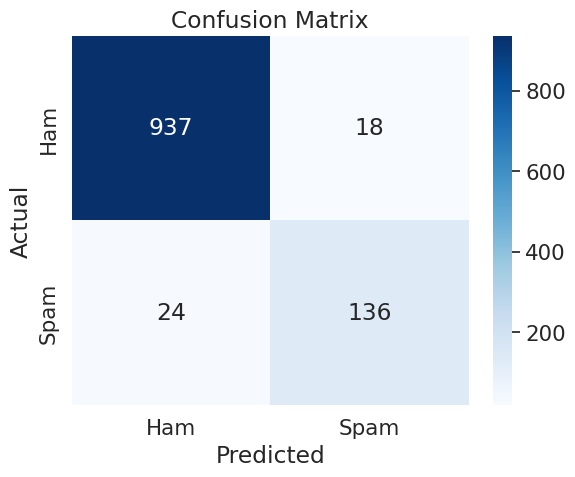

In [76]:
# 評估模型
print("traing_time:", end_time - start_time)
metrics = evaluate_model(model, test_loader)

## Generate text

### Data preprocess

In [29]:
file_path = 'SpamVsHam.tsv'
data = read_tsv(file_path)

# convert to dataframe and set the column name
data = pd.DataFrame(data,  columns=['label', 'text'])
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [30]:
spam_datas = data.loc[data['label'] == 'spam'].values

spam_texts = []
for spam_data in spam_datas:
    spam_texts.append(spam_data[1])

len(spam_texts)

747

In [31]:
# 數據預處理
def create_char_mapping(texts):
    chars = sorted(list(set(''.join(texts))))
    char_to_int = {c: i for i, c in enumerate(chars)}
    int_to_char = {i: c for c, i in char_to_int.items()}
    return char_to_int, int_to_char

char_to_int, int_to_char = create_char_mapping(spam_texts)
n_chars = len(char_to_int)
n_vocab = len(char_to_int)

In [32]:
import numpy as np


# 建立訓練數據
seq_length = 50
dataX = []
dataY = []
for text in spam_texts:
    for i in range(0, len(text) - seq_length, 1):
        seq_in = text[i:i + seq_length]
        seq_out = text[i + seq_length]
        dataX.append([char_to_int[char] for char in seq_in])
        dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)

# 將X重新形狀為LSTM的輸入尺寸並進行標準化
X = np.reshape(dataX, (n_patterns, seq_length, 1)) / float(n_vocab)
y = torch.nn.functional.one_hot(torch.tensor(dataY), n_vocab)

### Define model

- **input_dim**
  - **說明**：輸入特徵的維度，表示每個輸入元素的特徵數量。
  - **範例值**：在此模型中設定為 1，表示每個時間點的輸入是單維的。

- **hidden_dim**
  - **說明**：LSTM 層中隱藏狀態的維度，控制模型的記憶力和學習能力。
  - **範例值**：設定為 256，意味著每個 LSTM 單元的隱藏層將有 256 個神經元。

- **output_dim**
  - **說明**：模型輸出的維度，通常等於應用的詞彙表大小。
  - **範例值**：使用 `n_vocab` 作為輸出維度，代表不同字符的總數。

- **n_layers**
  - **說明**：LSTM 單元堆疊的層數，影響模型的學習深度和複雜性。


In [33]:
# 定義LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        logits = self.fc(lstm_out[:, -1, :])
        return logits

model = LSTMModel(1, 256, n_vocab, 2)

### Training!

In [34]:
import torch.optim as optim

# 設置訓練參數
n_epochs = 20
batch_size = 128

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 將數據切分成批次
def batch_data(data, batch_size):
    for i in range(0, len(data) - batch_size + 1, batch_size):
        yield data[i:i+batch_size]

# 訓練模型
model.train()
for epoch in range(n_epochs):
    total_loss = 0
    for i in range(0, len(dataX), batch_size):
        batch_x = dataX[i:i+batch_size]
        batch_y = dataY[i:i+batch_size]
        
        # 將數據轉換為適合模型的格式
        batch_x = torch.tensor(np.reshape(batch_x, (len(batch_x), seq_length, 1)), dtype=torch.float32) / float(n_vocab)
        batch_y = torch.tensor(batch_y, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {total_loss / len(dataX):.4f}')

print("Training completed.")


Epoch 1/20, Loss: 0.0282
Epoch 2/20, Loss: 0.0250
Epoch 3/20, Loss: 0.0233
Epoch 4/20, Loss: 0.0221
Epoch 5/20, Loss: 0.0212
Epoch 6/20, Loss: 0.0203
Epoch 7/20, Loss: 0.0194
Epoch 8/20, Loss: 0.0186
Epoch 9/20, Loss: 0.0178
Epoch 10/20, Loss: 0.0170
Epoch 11/20, Loss: 0.0162
Epoch 12/20, Loss: 0.0156
Epoch 13/20, Loss: 0.0149
Epoch 14/20, Loss: 0.0143
Epoch 15/20, Loss: 0.0138
Epoch 16/20, Loss: 0.0133
Epoch 17/20, Loss: 0.0128
Epoch 18/20, Loss: 0.0123
Epoch 19/20, Loss: 0.0120
Epoch 20/20, Loss: 0.0116
Training completed.


### generate_text 參數說明


model：這是已訓練的 LSTM 模型，用於預測序列的下一個字符。

seed：種子字符串，用作生成文本的初始輸入。模型將使用這個種子來開始生成過程，逐步擴展成更長的文本。

n_vocab：詞彙大小，即模型能識別的不同字符的數量。這個參數用於對輸入數據進行正規化，確保模型輸入在合適的數值範圍內。

int_to_char：這是一個字典，用於將數字索引映射回字符。在生成過程中，模型會輸出下一個字符的index，這個字典將索引轉換為對應的字符。

num_sentences：要生成的句子數量。指定生成多個獨立的句子。

length：每個句子的目標長度。這個參數控制每個生成的句子包含的字符數。

In [35]:
# 文本生成函數
def generate_text(model, seed, n_vocab, int_to_char, num_sentences=1, length=50):
    model.eval()
    sentences = []
    for _ in range(num_sentences):
        pattern = [char_to_int[char] for char in seed]
        sentence = seed
        for _ in range(length):
            x = np.reshape(pattern, (1, len(pattern), 1)) / float(n_vocab)
            x = torch.tensor(x, dtype=torch.float32)
            prediction = model(x)
            index = torch.argmax(prediction).item()
            result = int_to_char[index]
            sentence += result
            pattern.append(index)
            pattern = pattern[1:len(pattern)]
        sentences.append(sentence)
    return sentences

### Save SPAM-like sentences

In [36]:
from tqdm import tqdm


spam_like_sentences = []

for spam_text in tqdm(spam_texts[:100]):
    generated_sentences = generate_text(model, spam_text, n_vocab, int_to_char)
    # print(generated_sentences[0])
    spam_like_sentences.append(generated_sentences[0])

spam_like_sentences[:5]

100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


["Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's1.5+per aodomatt. T&Cs SAE 3807772221 brrm landlin",
 "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv pobet wot hr areem 4 flaim is aasy wr base ir 090",
 'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only. Canl The Mobile Update co toe lho £1000 crare. Ca',
 'Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030 brwm land line. Claim 3030. Valid 12hrs only 150p',
 'SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 infot. Cus Coee  Call Tteot wiuh 

In [37]:
# Save spam-like sentences to Dataframe
spam_like_data = {
    'label': ['spam'] * 100,
    'text': spam_like_sentences
}

# 使用字典創建 DataFrame
spam_like_data = pd.DataFrame(spam_like_data)

# 顯示 DataFrame
spam_like_data.head()

,label,text
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...
1,spam,FreeMsg Hey there darling it's been 3 week's n...
2,spam,WINNER!! As a valued network customer you have...
3,spam,Had your mobile 11 months or more? U R entitle...
4,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


### Merge SPAM-like sentences to original dataset

In [38]:
file_path = 'SpamVsHam.tsv'
data = read_tsv(file_path)

# convert to dataframe and set the column name
data = pd.DataFrame(data,  columns=['label', 'text'])

merged_data = pd.concat([data, spam_like_data])

merged_data = merged_data.sample(frac=1).reset_index(drop=True)

merged_data.head()

,label,text
0,ham,Can you tell Shola to please go to college of ...
1,spam,U can WIN £100 of Music Gift Vouchers every we...
2,ham,Idea will soon get converted to live:)
3,ham,"Nope, I'm still in the market"
4,ham,Good FRIENDS CaRE for each Other.. CLoSE Frien...


### Retrain ML and DL model

#### ML model

In [78]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(data['text'], 
                                                  data['label'], 
                                                  test_size=0.20, 
                                                  random_state=0)

# 再將訓練集+驗證集分割成訓練集和驗證集
X_train, X_val, y_train, y_val = train_test_split(X_temp, 
                                                  y_temp, 
                                                  test_size=0.25, # 注意這裡設置為0.25是因為原本0.8的數據要再取0.2作為驗證集，0.25 * 0.8 = 0.2
                                                  random_state=0)

# check the size of our datasets
print('Size of training set:',X_train.shape)
print('Size of validation set:',X_val.shape)
print('Size of test set:', X_test.shape)

Size of training set: (3342,)
Size of validation set: (1115,)
Size of test set: (1115,)


In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF Vectorizer object
tfidf = TfidfVectorizer(decode_error='ignore', lowercase=True, min_df=2)

# Fit the model and transform the documents
train = tfidf.fit_transform(X_train.values.astype('U'))

val = tfidf.transform(X_val.values.astype('U'))

# Get the list of words and their corresponding TF-IDF values
print('Train size: ',train.shape)
print('Val size: ',val.shape)


Train size:  (3342, 2962)
Val size:  (1115, 2962)


In [80]:
from sklearn.naive_bayes import MultinomialNB

start_time = time.time()

# create the model, train it on the train dataset and print the scores
model = MultinomialNB() # as implemented in sklearn
model.fit(train, y_train)

end_time = time.time()
training_time = end_time - start_time

print(f"Training completed in {training_time:.3f} seconds")
print("Train score:", model.score(train, y_train))
print("Validation score:", model.score(val, y_val))

Training completed in 0.011 seconds
Train score: 0.9778575703171754
Validation score: 0.967713004484305


              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       972
        spam       1.00      0.75      0.86       143

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.97      0.97      0.97      1115



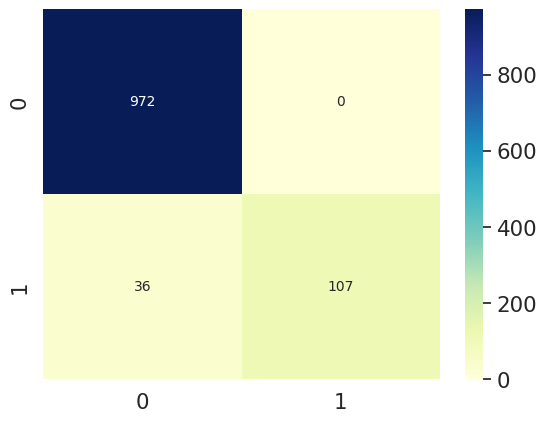

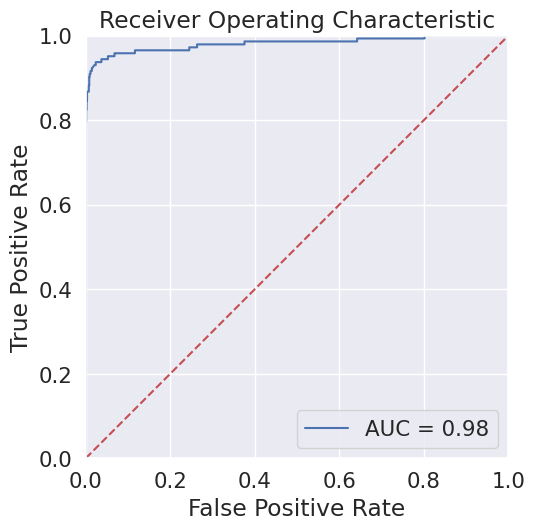

In [81]:
from sklearn import metrics

# Predicting the Test set results
y_pred = model.predict(val)

#print the classification report to highlight the accuracy with f1-score, precision and recall
print(metrics.classification_report(y_val, y_pred))
plot_confusion_matrix(y_val, y_pred)

# ROC curve needs the raw model probabilities, not the model predictions
y_pred_prob = model.predict_proba(val)[:,1]
plot_roc_curve(y_val.apply(lambda x: 1 if x == 'spam' else 0), y_pred_prob)

#### DL model

In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 將TF-IDF向量和標籤轉換成Tensor
train_data = torch.tensor(train.toarray(), dtype=torch.float32)
val_data = torch.tensor(val.toarray(), dtype=torch.float32)
test_data = torch.tensor(test.toarray(), dtype=torch.float32)
train_labels = torch.tensor(y_train.apply(lambda x: 1 if x == 'spam' else 0).values, dtype=torch.float32)
val_labels = torch.tensor(y_val.apply(lambda x: 1 if x == 'spam' else 0).values, dtype=torch.float32)
test_labels = torch.tensor(y_test.apply(lambda x: 1 if x == 'spam' else 0).values, dtype=torch.float32)

# 創建DataLoaders
train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
test_dataset = TensorDataset(test_data, test_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定義LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            layer_dim,
            batch_first=True
        )
        # Dropout 層
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # 輸入x的維度應為(batch_size, 1, input_dim)
        x = x.unsqueeze(1)  # 增加序列維度
        
        # 初始化隱藏狀態和單元狀態
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        
        # 前向傳播
        out, (hn, cn) = self.lstm(x, (h0, c0))
        # Dropout 層
        out = self.drop(out[:, -1, :])
        # 全連接層
        out = self.fc(out)
        return torch.sigmoid(out)

# 實例化模型
input_dim = train_data.shape[1]  # TF-IDF特徵數量
hidden_dim = 100
layer_dim = 1
output_dim = 1
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

# 損失函數和優化器
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 訓練模型
def train_model(num_epochs):
    training_loss = []
    validation_loss = []
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        
        # 訓練階段
        model.train()
        for texts, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * texts.size(0)
        
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        training_loss.append(avg_train_loss)
        
        # 驗證階段
        model.eval()
        total_correct = 0
        total = 0
        with torch.no_grad():
            for texts, labels in val_loader:
                outputs = model(texts)
                loss = criterion(outputs.squeeze(), labels)
                total_val_loss += loss.item() * texts.size(0)
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                total_correct += (predicted == labels).sum().item()
        
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        validation_loss.append(avg_val_loss)
        
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
        print(f'Validation Accuracy: {100 * total_correct / total}%')
    
    return training_loss, validation_loss

# 訓練模型並繪圖
start_time = time.time()
training_loss, validation_loss = train_model(10)
end_time = time.time()

Epoch 1, Training Loss: 0.28154065482483376, Validation Loss: 0.07252357748124097
Validation Accuracy: 98.11659192825113%
Epoch 2, Training Loss: 0.0394537100431307, Validation Loss: 0.06625454366716636
Validation Accuracy: 97.847533632287%
Epoch 3, Training Loss: 0.01793649013525435, Validation Loss: 0.06488804360872527
Validation Accuracy: 98.02690582959642%
Epoch 4, Training Loss: 0.0083956540062379, Validation Loss: 0.06945171899108984
Validation Accuracy: 97.847533632287%
Epoch 5, Training Loss: 0.003955247869623412, Validation Loss: 0.07384995466174929
Validation Accuracy: 97.9372197309417%
Epoch 6, Training Loss: 0.0024080122617079766, Validation Loss: 0.08021016828592469
Validation Accuracy: 98.02690582959642%
Epoch 7, Training Loss: 0.0013805825879754424, Validation Loss: 0.08340630689776825
Validation Accuracy: 98.02690582959642%
Epoch 8, Training Loss: 0.0006099211145484991, Validation Loss: 0.08748766849450247
Validation Accuracy: 98.02690582959642%
Epoch 9, Training Loss: 

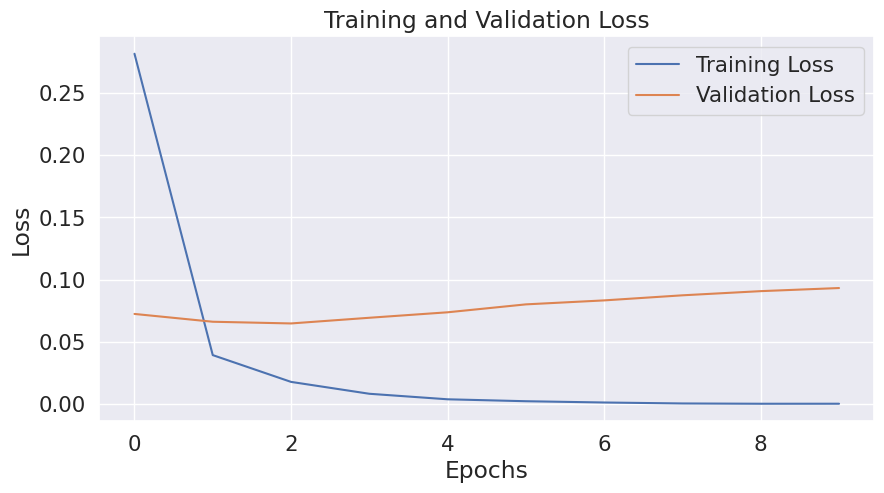

Total training time: 4.57 seconds


In [83]:
# 繪製損失圖
plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f'Total training time: {end_time - start_time:.2f} seconds')

Classification Report:
              precision    recall  f1-score   support

           1     0.9803    0.9313    0.9551       160
           0     0.9886    0.9969    0.9927       955

    accuracy                         0.9874      1115
   macro avg     0.9844    0.9641    0.9739      1115
weighted avg     0.9874    0.9874    0.9873      1115



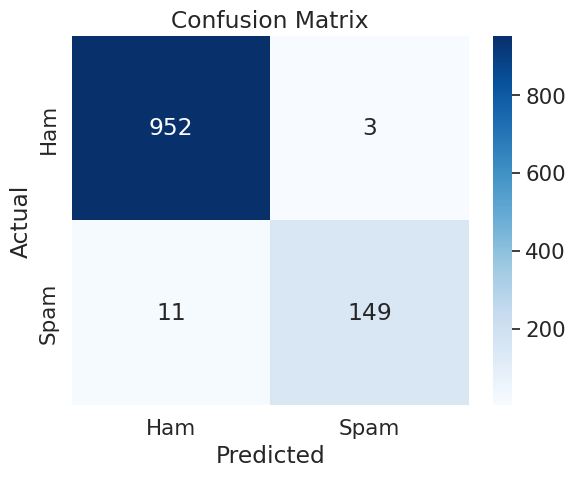

In [85]:
# 評估模型
metrics = evaluate_model(model, test_loader)